# Detection of Road Lane Line



***
In this project, I have used the tools that I learned about in the Computer Vision Fundamentals lesson to identify lane lines on the road.  I have developed my pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "test_videos_output/solidWhiteRight.mp4" (also contained in this repository) to see what the output looks like. 



---

## Import Packages

In [11]:
#importing some useful packages
from moviepy import *
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
import os
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


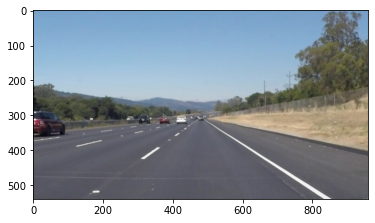

In [12]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


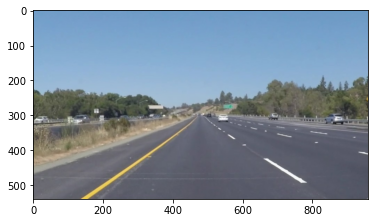

In [13]:
#reading in an image
image2 = mpimg.imread('test_images/solidYellowLeft.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image2)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


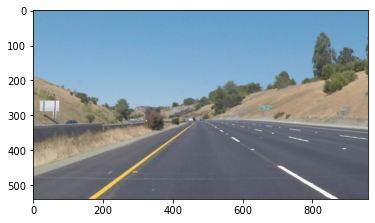

In [16]:
#reading in an image
image3 = mpimg.imread('test_images/solidYellowCurve2.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image3)

## Lane Detection Pipeline

### Helper Functions

In [3]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def drawLine(img, imshape, coef, intercept, intersection, color, thickness):
    if not math.isnan(intersection):
        x1, y1 = (int(intersection), int(intersection * coef + intercept))
        if coef > 0:
            x2, y2 = (imshape[1], int(imshape[1] * coef + intercept))
        elif coef < 0:
            x2, y2 = (0, int(0 * coef + intercept))
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def fitLine(slopePoints):
    
    requiredSlopes = []
    requiredIntercepts = []
    if len(slopePoints) == 1:
        return slopePoints[0][0], slopePoints[0][1]
    
    slopes = [each[0] for each in slopePoints]
    meanSlope = np.mean(slopes)
    sdSlope = np.std(slopes)
    
    for eachXY in slopePoints:
        slope = eachXY[0]
        if slope - meanSlope < 1.5 * sdSlope:
            requiredSlopes.append(slope)
            requiredIntercepts.append(eachXY[1])
    if not requiredSlopes:
        requiredSlopes = slopes
        requiredIntercepts = [eachXY[1] for eachXY in slopePoints]
    requiredSlope = np.mean(requiredSlopes)
    requiredIntercept = np.mean(requiredIntercepts)
    return requiredSlope, requiredIntercept

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    imshape = [img.shape[0], img.shape[1]]
    
    posSlope = []
    negSlope = []
    posIntercept = []
    negIntercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1 - y2) / (x1 - x2)
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        posSlope.append([x1, y1])
                        posSlope.append([x2, y2])
                        posIntercept.append([slope, y1-(slope*x1)])
                    elif slope < 0:
                        negSlope.append([x1, y1])
                        negSlope.append([x2, y2])
                        negIntercept.append([slope, y1-(slope*x1)])
    if not posSlope:
        for line in lines:
            for x1, y1, x2, y2 in line:
                slope = (y1 - y2)/(x1 - x2)
                if slope > 0:
                    posSlope.append([x1, y1])
                    posSlope.append([x2, y2])
                    posIntercept.append([slope, y1-slope*x1])
    if not negSlope:
        for line in lines:
            for x1, y1, x2, y2 in line:
                slope = (y1 - y2)/(x1 - x2)
                if slope < 0:
                    negSlope.append([x1, y1])
                    negSlope.append([x2, y2])
                    negIntercept.append([slope, y1-slope*x1])
    
    posCoef, posIntercept = fitLine(posIntercept)
    negCoef, negIntercept = fitLine(negIntercept)
    
    intersection = (negIntercept - posIntercept) / (posCoef - negCoef)
    
    drawLine(img, imshape, posCoef, posIntercept, intersection, color, thickness)
    drawLine(img, imshape, negCoef, negIntercept, intersection, color, thickness)       
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Pipeline

In [4]:
def process_image(image):
    imshape = image.shape
    #Convert to grayscale
    grayscaleImage = grayscale(image)
    #plt.imshow(grayscaleImage)
    #Apply gaussian blur
    gaussianImage = gaussian_blur(grayscaleImage, 5)
    #plt.imshow(gaussianImage)
    #Fine the edges in the image
    cannyImage = canny(gaussianImage, 50, 150)
    #plt.imshow(cannyImage)
    #Limit to a region of interest, in this case the lanes
    roiMask = np.array([[(0, imshape[0]), (465, 320), (475, 320), (imshape[1], imshape[0])]], dtype=np.int32)
    edgeMask = region_of_interest(cannyImage, roiMask)
    #Only the required edges are displayed and rest is set to black
    edgeMaskImage = cv2.cvtColor(edgeMask, cv2.COLOR_GRAY2BGR)
    #plt.imshow(edgeMaskImage)
    
    #Hough lines
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 40
    max_line_gap = 20
    linesImage = hough_lines(edgeMask, rho, theta, threshold, min_line_len, max_line_gap)    
    
    #colorEdges = np.dstack((cannyImage, cannyImage, cannyImage))
    
    result = cv2.addWeighted(image, 0.8, linesImage, 1, 0)
    return result

## Clips

In [5]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip('test_videos/solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: total: 3.31 s
Wall time: 2.98 s


In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [7]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: total: 11.1 s
Wall time: 9.37 s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [9]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: total: 7.53 s
Wall time: 7.4 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))